In [1]:
import os
import umap
import json
import torch
import ncvis
import itertools
from core import *
import numpy as np
import pandas as pd
import pickle as pkl
from torch import nn
import os.path as op
from tqdm import tqdm
from time import time
from Bio import SeqIO
from scipy import stats
from weblogolib import *
from copy import deepcopy
from torch.optim import Adam
from tpot import TPOTRegressor
import torch.nn.functional as F
import matplotlib.pyplot as plt
from capsules.capsules import *
from matplotlib import rcParams
from IPython.display import Image
from matplotlib.lines import Line2D
from torch.autograd import Variable
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from scipy.stats import spearmanr, pearsonr
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.metrics import accuracy_score, matthews_corrcoef, precision_score, recall_score

In [2]:
from matplotlib import cm

In [3]:
np.random.seed(1341)
torch.manual_seed(1341)

In [4]:
encoder = GuideHN(21, 32, 1360, n_classes=5).cuda()
model = DKL(encoder, [1,5*32]).cuda()
model.load_state_dict(torch.load("../models/DeepHF/WT/CNN59.ptch"))
model = model.eval()

In [5]:
transformer = get_Cas9_transformer(True)

In [6]:
GENE_TABLE = "../results/Chr22/DeepHF/WT/chr22_grnas/LOC440792.tsv"

In [7]:
current_df = pd.read_csv(GENE_TABLE, sep="\t", header=None).dropna()
current_df = current_df[current_df[3].apply(lambda x: len(x) == 23)]
tds = DeepHFDataset(
    current_df, np.arange(current_df.shape[0]), transformer, sequence_column=3, 
    label_column=5
)
tld = DataLoader(tds, shuffle=False, batch_size=256)
tb_oa = []
tb_va = []
tb_ra = []
for transformed_batch, _ in tqdm(tld):
    tb_o = encoder(transformed_batch)[0].cpu().data.numpy()
    tb_ra.extend(tb_o)
    tb = model(transformed_batch)
    tb_o = model.likelihood(
        tb[0]
    ).mean.mean(0).cpu().data.numpy()
    tb_v = model.likelihood(
        tb[0]
    ).variance.mean(0).cpu().data.numpy()
    tb_oa.extend(tb_o)
    tb_va.extend(tb_v)

100%|██████████| 11/11 [00:02<00:00,  5.34it/s]


In [8]:
tb_ra = np.stack(tb_ra).reshape(-1, 5*32)

In [9]:
nvis_cm = ncvis.NCVis(random_seed=1341)
nv_cm = nvis_cm.fit_transform(tb_ra)

In [10]:
uvis_cm = umap.UMAP(random_state=1341)
uvis_cm.fit(tb_ra)

UMAP(dens_frac=0.0, dens_lambda=0.0, random_state=1341)

In [11]:
pvis_cm = PCA(random_state=1341)
pv_cm = pvis_cm.fit_transform(tb_ra)

In [12]:
data = pd.read_csv(
    "/home/bakirillov/Data/Svetlana_data/Table_S8_machine_learning_input.txt", index_col=0, sep="\t"
)
sequence_tuples = list(zip(data['genome input'], data['sgRNA input']))

In [13]:
def binarize_sequence(sequence):
    """
    converts a 26-base nucleotide string to a binarized array of shape (4,26)
    """
    arr = np.zeros((4, 23))
    for i in range(23):
        if sequence[i] == 'A':
            arr[0,i] = 1
        elif sequence[i] == 'C':
            arr[1,i] = 1
        elif sequence[i] == 'G':
            arr[2,i] = 1
        elif sequence[i] == 'T':
            arr[3,i] = 1
        else:
            raise(
                Exception(
                    'sequence contains characters other than A,G,C,T \n%s'%sequence
                )
            )
    return(arr)

GTGGGGCGAGGCGGTGAGTGTGG
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]]
(4, 23)


[]

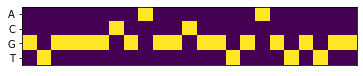

In [14]:
test_sequence = sequence_tuples[0][0][2:-1]
print(test_sequence)
print(binarize_sequence(test_sequence))
print(binarize_sequence(test_sequence).shape)
fig,ax=plt.subplots()
ax.imshow(binarize_sequence(test_sequence))
ax.set_yticks(range(4))
ax.set_yticklabels(list('ACGT'))
ax.set_xticks([])

In [15]:
stacked_arrs = [np.stack((binarize_sequence(genome_input[2:-1]), binarize_sequence(sgrna_input[2:-1])), axis=2) 
                for (genome_input, sgrna_input) in sequence_tuples]

In [16]:
from collections import Counter
from keras.layers import Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout
from keras.models import Sequential

In [17]:
X = np.concatenate([arr[np.newaxis] for arr in stacked_arrs])
y = data['mean relative gamma'].values
series = data['perfect match sgRNA']
print('X:', X.shape)
print('y:', y.shape)
print('series:', series.shape)
val_series = np.random.choice(
    np.unique(series), size=int(len(np.unique(series))*.20), replace=False
)
val_indices = np.where(np.isin(series, val_series))
train_indices = np.where(~np.isin(series, val_series))
X_train = X[train_indices]
X_val = X[val_indices]
y_train = y[train_indices]
y_val = y[val_indices]
nbins=5
y_train_clipped = y_train.clip(0,1)
y_train_binned, histbins = pd.cut(
    y_train_clipped, np.linspace(0,1,nbins+1), 
    labels=range(nbins), include_lowest=True, retbins=True
)
print('bin edges:', histbins)
class_weights = {k:1/float(v) for k,v in Counter(y_train_binned).items()}
class_weights[0] = class_weights[0] * 1.5
class_weights = {k:v/sum(class_weights.values()) for k,v in class_weights.items()}
sample_weights = [class_weights[Y] for Y in y_train_binned]
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(4,4), activation='relu', padding='same', input_shape=(4,23,2), data_format='channels_last'))
model.add(Conv2D(filters=32, kernel_size=(4,4), activation='relu', padding='same', data_format='channels_last'))
model.add(MaxPool2D(pool_size=(1,2), padding='same', data_format='channels_last'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(units=128, activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(units=32, activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))
model.compile(loss='logcosh', metrics=['mse'], optimizer='adam')

# train the model for 8 epochs

model_history = model.fit(X_train, 
                          y_train.ravel(), 
                          sample_weight=np.array(sample_weights), 
                          batch_size=32, 
                          epochs=8, 
                          validation_data=(X_val, y_val.ravel()))

print('r squared = %.3f'%pearsonr(y_val, model.predict(X_val).ravel())[0]**2)
model.save("Original_Jost_et_al.keras")
with open("../models/JostEtAl/model-u.json", "r") as ih:
    t = json.loads(ih.read())
orig_predictions = model.predict(X_val)
y_hat_scaled = orig_predictions/np.max(orig_predictions)
y_val_scaled = y_val/np.max(y_val)

X: (26248, 4, 23, 2)
y: (26248,)
series: (26248,)
bin edges: [0.  0.2 0.4 0.6 0.8 1. ]
Epoch 1/8
657/657 [==============================] - 10s 14ms/step - loss: 0.0087 - mse: 0.1985 - val_loss: 0.0404 - val_mse: 0.0843
Epoch 2/8
657/657 [==============================] - 8s 13ms/step - loss: 0.0045 - mse: 0.0896 - val_loss: 0.0372 - val_mse: 0.0775
Epoch 3/8
657/657 [==============================] - 8s 13ms/step - loss: 0.0038 - mse: 0.0738 - val_loss: 0.0301 - val_mse: 0.0631
Epoch 4/8
657/657 [==============================] - 8s 12ms/step - loss: 0.0036 - mse: 0.0691 - val_loss: 0.0339 - val_mse: 0.0709
Epoch 5/8
657/657 [==============================] - 8s 13ms/step - loss: 0.0033 - mse: 0.0610 - val_loss: 0.0317 - val_mse: 0.0661
Epoch 6/8
657/657 [==============================] - 8s 13ms/step - loss: 0.0032 - mse: 0.0587 - val_loss: 0.0309 - val_mse: 0.0646
Epoch 7/8
657/657 [==============================] - 8s 13ms/step - loss: 0.0030 - mse: 0.0567 - val_loss: 0.0312 - val_

In [21]:
from sklearn.metrics import roc_auc_score, roc_curve, balanced_accuracy_score

In [20]:
PENGPATH = "/home/bakirillov/Data/CRISPR-CAD/Peng_offtargets/bty558-suppl_data/"
HPATH = "/home/bakirillov/Data/CRISPR-CAD/Haeussler/13059_2016_1012_MOESM2_ESM.tsv"
LOW = op.join(PENGPATH, "Supplementary file 1.xlsx")
HIGH = op.join(PENGPATH, "Supplementary file 1.xlsx")
NEG = op.join(PENGPATH, "Supplementary file 1.xlsx")
UNDERSAMPLE = False
low = pd.read_excel(op.join(PENGPATH, "Supplementary file 1.xlsx"), sheet_name=0, engine='openpyxl')
high = pd.read_excel(op.join(PENGPATH, "Supplementary file 1.xlsx"), sheet_name=1, engine='openpyxl')
neg = pd.read_excel(op.join(PENGPATH, "Supplementary file 1.xlsx"), sheet_name=2, engine='openpyxl')
low_strs = [a+","+b for a,b in zip(low["on-target site"], low["off-target site"])]
high_strs = [a+","+b for a,b in zip(high["on-target site"], high["off-target site"])]
neg_strs = [a+","+b for a,b in zip(neg["on-target site"], neg["no editing site"])]
low_high = list(set(low_strs+high_strs))
final_neg = []
if UNDERSAMPLE:
    for a in tqdm(low_high):
        suitable = list(
            filter(
                lambda x: x.split(",")[0] == a.split(",")[0] and x.split(",")[0] not in final_neg, 
                neg_strs
            )
        )
        final_neg.append(np.random.choice(suitable))
    final_neg = list(set(final_neg))
else:
    final_neg = neg_strs
pairs = np.array(low_high+final_neg)
labels = np.array([1]*len(low_high)+[0]*len(final_neg))
guides = np.unique([a.split(",")[0] for a in pairs])
folds = {a: np.array([a not in b for b in pairs]) for a in guides}
u = ImperfectMatchTransform("NGG", False, False, fold=False)
transformer = transforms.Compose(
    [
        u, ToTensor(True)
    ]
)
tt_X, val_X, tt_Y, val_Y = train_test_split(
    np.arange(len(pairs)), labels, test_size=0.1, stratify=labels
)
train_X, test_X, train_Y, test_Y = train_test_split(
    tt_X, tt_Y, stratify=tt_Y
)
BATCH_SIZE=256
encoder = GuideHN2d(
    23, capsule_dimension=32, n_routes=1600, n_classes=5, n_channels=2,
).cuda()
model = DKL(encoder, [1,5*32]).cuda().eval()
model.load_state_dict(torch.load("../models/JostEtAl/modelRNN59.ptch"))
model = model.eval()

class PengDataset(Dataset):

    def __init__(self, pairs, labels, indices, transform=None):
        self.transform = transform
        self.S = np.array(pairs)[indices]
        self.L = np.array(labels)[indices]

    def __len__(self):
        return(len(self.S))

    def sp(self, x, a):
        first = x.split(",")[0] == a.split(",")[0]
        second = x.split(",")[0] not in self.final_neg
        return(first and second)

    def __getitem__(self, ind):
        sequence = self.S[ind] if not self.transform else self.transform(self.S[ind])
        target = self.L[ind]
        return(sequence, target)
    
pd = PengDataset(pairs, labels, np.arange(len(labels)), transform=transformer)
pd_loader = DataLoader(pd, shuffle=False, batch_size=BATCH_SIZE)

prediction_means = []
prediction_vars = []
for transformed_batch, label in tqdm(pd_loader):
    current = model(transformed_batch)
    current_mean = model.likelihood(
        current[0]
    ).mean.mean(0).cpu().data.numpy()
    current_var = model.likelihood(
        current[0]
    ).variance.mean(0).cpu().data.numpy()
    prediction_means.extend(current_mean)
    prediction_vars.extend(current_var)
prediction_means = np.array(prediction_means)
prediction_vars = np.array(prediction_vars)

100%|██████████| 1598/1598 [01:15<00:00, 21.15it/s]


NameError: name 'roc_curve' is not defined

In [22]:
X, Y, _ = roc_curve(y_true=labels, y_score=prediction_means)
from collections import Counter
from keras.layers import Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout
from keras.models import Sequential
sequence_tuples = list(zip([a.split(",")[0] for a in pairs], [a.split(",")[1] for a in pairs]))
stacked_arrs = [np.stack((binarize_sequence(genome_input), binarize_sequence(sgrna_input)), axis=2) 
                for (genome_input, sgrna_input) in sequence_tuples]
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(4,4), activation='relu', padding='same', input_shape=(4,23,2), data_format='channels_last'))
model.add(Conv2D(filters=32, kernel_size=(4,4), activation='relu', padding='same', data_format='channels_last'))
model.add(MaxPool2D(pool_size=(1,2), padding='same', data_format='channels_last'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(units=128, activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(units=32, activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))
model.compile(loss='logcosh', metrics=['mse'], optimizer='adam')
model.load_weights("Original_Jost_et_al.keras")
X_st = np.stack(stacked_arrs)
Y_hat = model.predict(X_st)
X_2, Y_2, _ = roc_curve(y_true=labels, y_score=Y_hat)

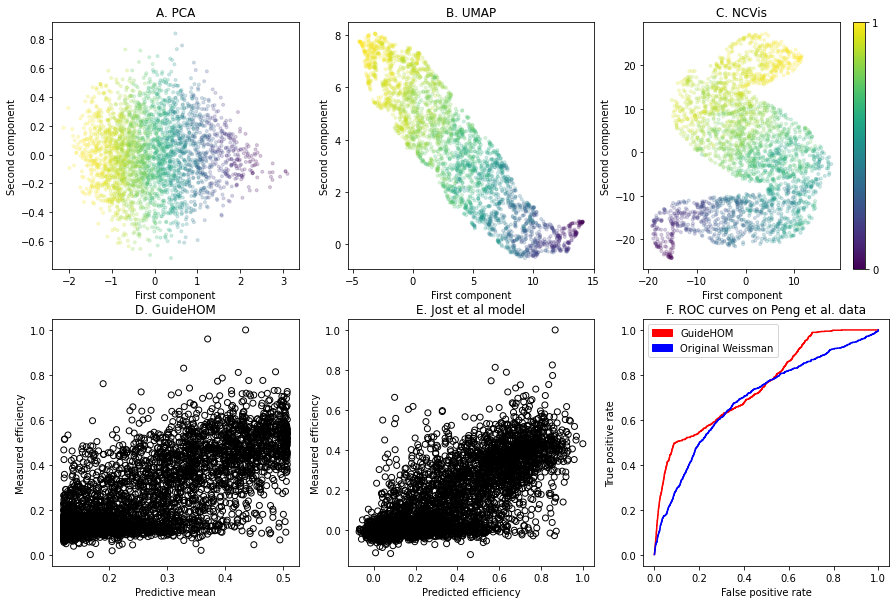

In [26]:
rcParams["figure.figsize"] = (15, 10)
data1 = np.random.normal(size=100)
fig, ax = plt.subplots(nrows=2, ncols=3)
ax[0][0].scatter(pv_cm.T[0], pv_cm.T[1], c=tb_oa, marker=".", alpha=0.2)
ax[0][0].set_title("A. PCA")
ax[0][0].set_xlabel("First component")
ax[0][0].set_ylabel("Second component")
ax[0][1].scatter(uvis_cm.embedding_.T[0], uvis_cm.embedding_.T[1], c=tb_oa, marker=".", alpha=0.2)
ax[0][1].set_title("B. UMAP")
ax[0][1].set_xlabel("First component")
ax[0][1].set_ylabel("Second component")
ax[0][2].scatter(nv_cm.T[0], nv_cm.T[1], c=tb_oa, marker=".", alpha=0.2)
ax[0][2].set_title("C. NCVis")
ax[0][2].set_xlabel("First component")
ax[0][2].set_ylabel("Second component")
fig.colorbar(cm.ScalarMappable(), ax=ax[0][2], ticks=range(10))

#fig,ax = plt.subplots(ncols=2)
ax[1][1].scatter(y_hat_scaled, y_val_scaled, edgecolors="black", facecolors='none')#, marker='.', alpha=.2)
ax[1][1].set_xlabel('Predicted efficiency')
ax[1][1].set_ylabel('Measured efficiency')
ax[1][1].set_title('E. Jost et al model');
ax[1][0].scatter(t["y_hat"], t["y"], edgecolors="black", facecolors='none')
ax[1][0].set_xlabel("Predictive mean")
ax[1][0].set_ylabel("Measured efficiency")
ax[1][0].set_title('D. GuideHOM');
#plt.show()

ax[1][2].plot(X, Y, color="red")
ax[1][2].plot(X_2, Y_2, color="blue")
ax[1][2].set_xlabel("False positive rate")
ax[1][2].set_ylabel("True positive rate")
ax[1][2].legend(
    loc="best", 
    handles=[Patch(color="red", label="GuideHOM"), Patch(color="blue", label="Original Weissman")]
)
ax[1][2].set_title("F. ROC curves on Peng et al. data")

plt.show()